<!-- # Notebook for Simulating $\hat c_j^i$ Distribution -->

In [60]:
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from numpy import linalg as LA

## Configuration

### $X^i$ ~ $N(0, I_d)$
### $w^i$ ~ $U[-10, 10]$

Creating the toy dataset with n = 200, $m_i$ = 10, and d = 10.

In [61]:
NUM_SAMPLES = 10
NUM_CLIENTS = 50
NUM_CLUSTERS = 2

## Creating Dataset

In [62]:
K = 3000
SUBSET_SIZE = 20
alpha = 0.01

In [63]:
%matplotlib notebook

In [64]:
# %matplotlib inline

## Non-parametric model

### DecisionTreeRegressor

In [65]:
from scipy import ndimage
from matplotlib.colors import ListedColormap

cm2 = ListedColormap(['#0000aa', '#ff2020'])
colors = np.array(['#0000aa', '#ff2020'])

def plot_tree_partition(X, y, tree, ax=None, min_value=0, max_value=6, eps=0.25):
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
#     x_min, y_min = min_value, min_value
#     x_max, y_max = max_value, max_value
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)
    

    ax.scatter(X[:, 0], X[:, 1], c=colors[y])
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

In [66]:
from sklearn.model_selection import train_test_split


def split_array_into_chunks(arr, k):
    return [arr[i:i+k] for i in range(0, len(arr), k)]


def get_test_non_param_data(n_points=1000):
    interval_size = 4
    clusters = []
    delta = 0.25

    points_X = np.random.uniform(0, interval_size, (n_points, 2))
    
    X = []
    y = []
    
    min_size = n_points
    
    cnt = 0
    for sub_interval1 in range(0, interval_size-1, 2):
        for sub_interval2 in range(0, interval_size-1, 2):            
            selected_idx = np.where((points_X[:, 0] >= sub_interval1) & (points_X[:, 0] < sub_interval1+2) 
                                  & (points_X[:, 1] >= sub_interval2) & (points_X[:, 1] < sub_interval2+2))[0]
            
            selected_x = points_X[selected_idx]
            
            selected_x[:, 0] = np.where(selected_x[:, 0] > sub_interval1+delta, selected_x[:, 0], sub_interval1+delta)
            selected_x[:, 0] = np.where(selected_x[:, 0] < sub_interval1+2-delta, selected_x[:, 0], sub_interval1+2-delta)

            selected_x[:, 1] = np.where(selected_x[:, 1] > sub_interval2+delta, selected_x[:, 1], sub_interval2+delta)
            selected_x[:, 1] = np.where(selected_x[:, 1] < sub_interval2+2-delta, selected_x[:, 1], sub_interval2+2-delta)

            
            selected_y = list(map(lambda x: int(x[0] + x[1] > (sub_interval1 + sub_interval2 + 2)), selected_x))
            if cnt != 0:
                selected_y = 1-np.array(selected_y)
        
            min_size = min(min_size, len(selected_idx))

            X.append(selected_x)
            y.append(selected_y)  
            cnt += 1
            
    new_X = []
    new_y = []
    X_tests = []
    y_tests = []

    for i in range(len(X)):
        X[i] = X[i][:143]
        y[i] = y[i][:143]

        _X, X_test, _y, y_test = train_test_split(X[i], y[i], test_size=0.3, random_state=42)
    
        X_test = np.array(X_test)
        y_test = np.array(y_test)


        
        x_chunks = split_array_into_chunks(_X, 10)
        new_X += x_chunks
        y_chunks = split_array_into_chunks(_y, 10)
        new_y += y_chunks
        for j in range(len(x_chunks)):
            random_indices = random.sample(range(len(X_test)), 30)
            X_tests.append(X_test[random_indices])
            y_tests.append(y_test[random_indices])
           
    
    X = np.array(new_X)
    y = np.array(new_y)
    X_test = np.array(X_tests)
    y_test = np.array(y_tests)
    
    return X, y, X_test, y_test, _X, _y


In [67]:
X, y, X_test, y_test, _X, _y = get_test_non_param_data()


<IPython.core.display.Javascript object>


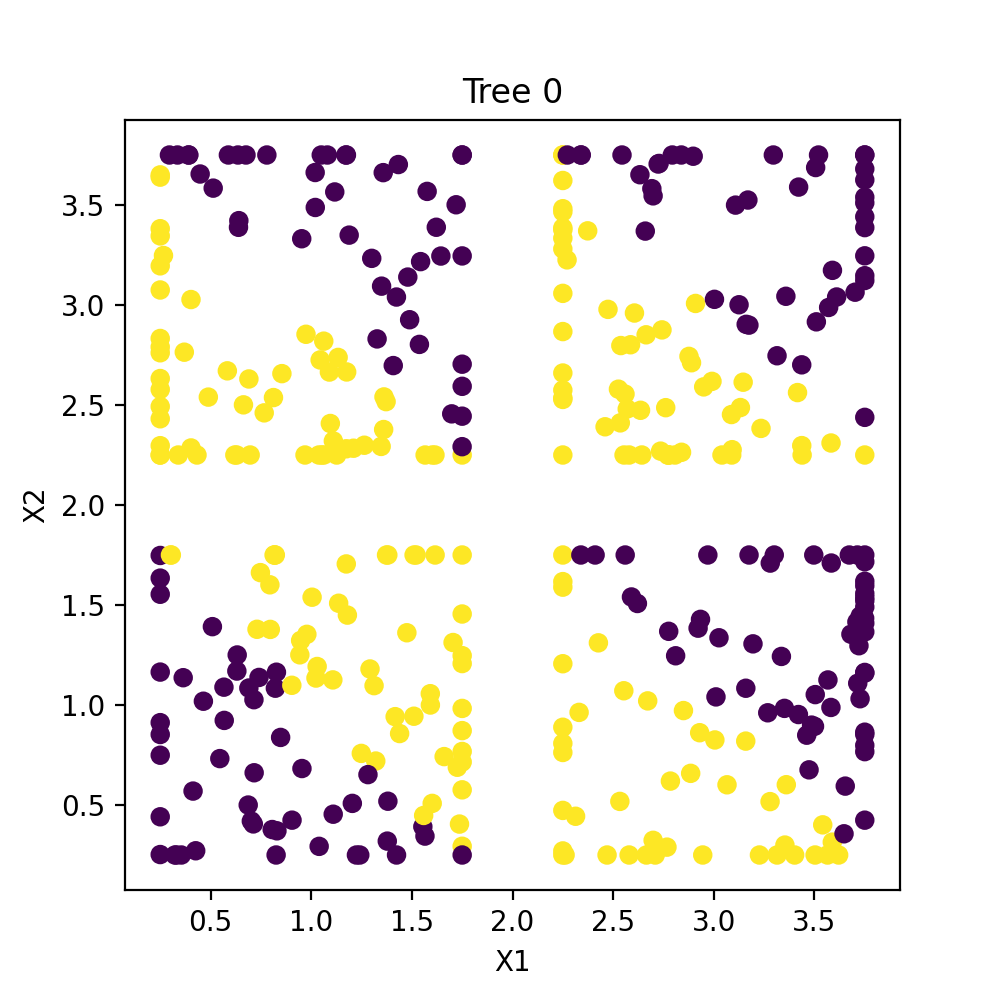

In [68]:


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for item in range(len(X)):
    ax.scatter(X[item, :, 0], X[item, :, 1], c=y[item])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('labels')
plt.savefig('non_param_datapoints.pdf')
plt.show()

In [69]:
from sklearn import tree
from sklearn.metrics import log_loss
from copy import deepcopy


def MSE(y_true, y_pred):
    logloss = log_loss(y_true, y_pred, labels=[0, 1])
    return logloss

def custom_log_loss(y_true, y_pred, lambda_value):
    logloss = log_loss(y_true, y_pred, labels=[0, 1])
    return lambda_value * (logloss)

def non_param_algorithm(X, X_test, y, y_test, _X, _y, K, subset_size, alpha):
    N = X.shape[0]
    nodes = [i for i in range(N)]
    w_hat = [tree.DecisionTreeClassifier(max_depth=2) for _ in range(N)]
    loss_history = []
    
    loss = []
    for i in range(N):
        if i != 0:
            continue
        w_hat[i].fit(X[i], y[i])
        mse = MSE(y_test[i], w_hat[i].predict(X_test[i]))
        loss.append(mse)
    loss_history.append(np.mean(loss))
    
    mse = 0
    rewards = []
    new_X = [X[i] for i in range(N)]
    new_y = [y[i] for i in range(N)]
    plot_data = [[], [], []]
    sample_weighs = [np.ones_like(new_y[i]) for i in range(N)]
    for k in range(K):
        loss = []
        for i in range(N):
            if i != 0:
                continue
            selected_nodes = random.sample(nodes, subset_size+1)
            random.shuffle(selected_nodes)
            while i in selected_nodes:
                selected_nodes.remove(i)
                
            selected_nodes = selected_nodes[:subset_size] 
            
            rewards = []
            _trees = []
            _Xs = []
            _ys = []
            _sample_weights = []
            for node in selected_nodes:
                _X = np.concatenate([new_X[i], X_test[node]])
                _Xs.append(_X)
                _y = np.concatenate([w_hat[i].predict(new_X[i]), y_test[node]])
                _ys.append(_y)
                sample_weight = np.concatenate([sample_weighs[i], np.ones_like(y_test[node]) * alpha])
                _sample_weights.append(sample_weight)
                
                _tree = tree.DecisionTreeClassifier(max_depth=2)
                _tree.fit(_X, _y, sample_weight=sample_weight)
                _trees.append(_tree)
                
                updated_loss = custom_log_loss(y_test[node], _tree.predict(X_test[node]), alpha)
                rewards.append(updated_loss)
                
            idx = np.argmin(rewards)
            current_loss = custom_log_loss(y_test[i], w_hat[i].predict(X_test[i]), alpha)
            
            if True:
                best_tree = _trees[idx]
                new_X[i] = _Xs[idx]
                new_y[i] = _ys[idx]
                sample_weighs[i] = _sample_weights[idx]
            

                w_hat[i] = deepcopy(best_tree)  
            
            if i == 0:
                ax.set_title("Tree {}".format(0))
                plot_data[0].append(new_X[0])
                plot_data[1].append(new_y[0])
                plot_data[2].append(w_hat[0])

            
            mse = MSE(_y, w_hat[i].predict(_X))
            loss.append(mse)
        loss_history.append(np.mean(loss))
        
    return w_hat, loss_history, w_hat, plot_data

In [70]:
alpha = 0.7
# print(len(X), len(X[0]), len(X_test[0]), alpha)

In [71]:
K = 1000
results = []
_, algo_loss_history, w_hat, plot_data = non_param_algorithm(X, X_test, y, y_test, _X, _y, K, 20, alpha)

<IPython.core.display.Javascript object>


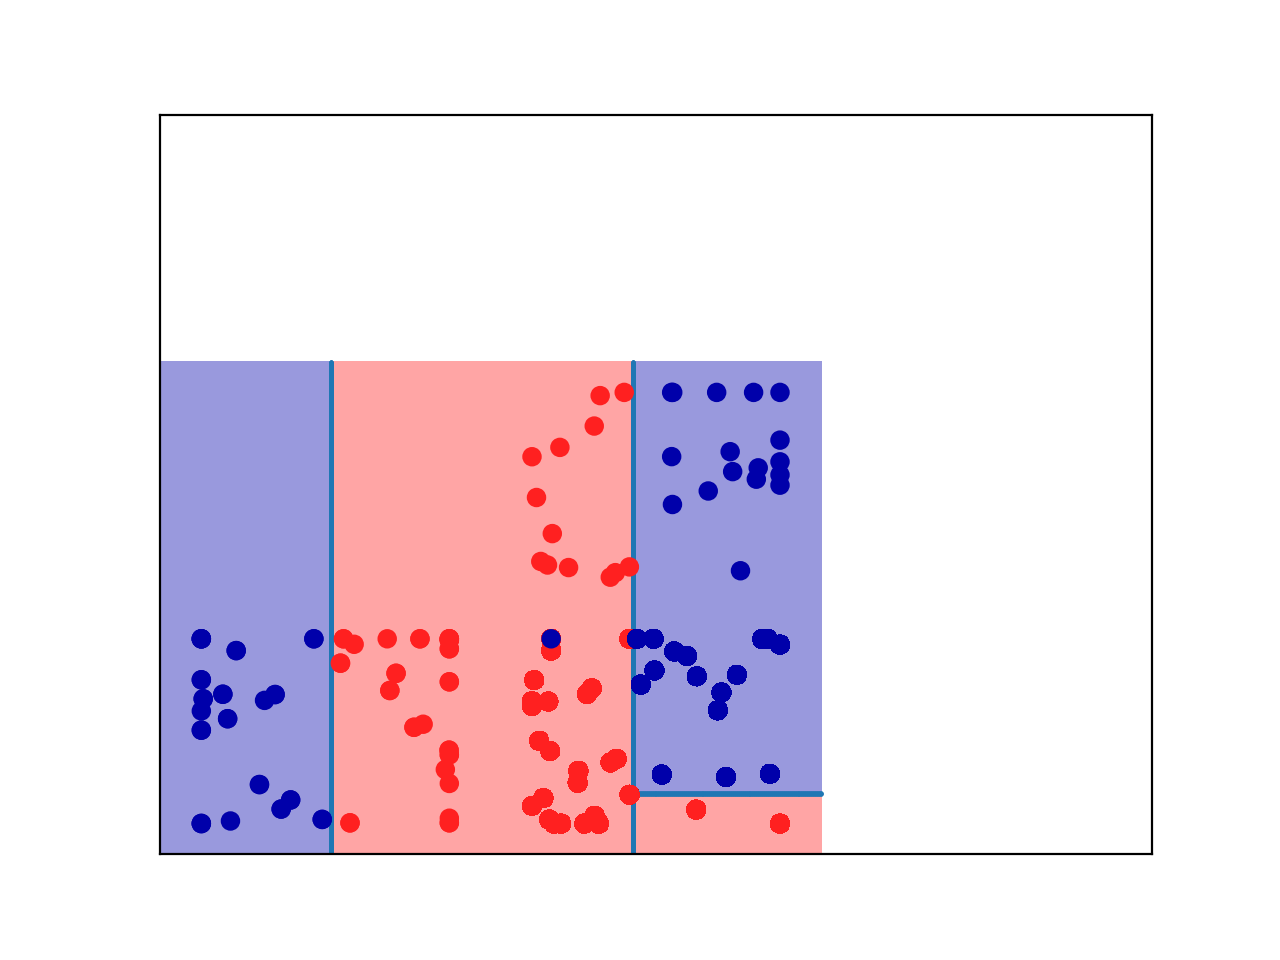

In [72]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
from IPython.display import HTML


# Example data
_x = plot_data[0]
_y = plot_data[1]
_w = plot_data[2]

# Create a figure and axis object
fig, ax = plt.subplots()

# Define the update function
def update(frame):
    X = _x[frame]
    y = _y[frame]
    tree = _w[frame]
    min_value=0
    max_value=6
    eps=0.25
    
    ax.clear()
    
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)
    

    ax.scatter(X[:, 0], X[:, 1], c=colors[y])
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xticks(())
    ax.set_yticks(())
#     time.sleep(2)

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=len(_x), interval=100, blit=True)

# Show the plot
# plt.show()

In [74]:
ani.save('animation.mp4', writer='ffmpeg')

In [77]:
# ![Animation](animation.mp4)


<video width="320" height="240" 
       src="animation.mp4"  
       controls>
</video>

In [73]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [53]:
from matplotlib.animation import ImageMagickWriter

convert_path = './data'
writer = ImageMagickWriter(fps=10)

ani.save("animation.gif", writer=writer)

CalledProcessError: Command '['convert', '-size', '1280x960', '-depth', '8', '-delay', '10.0', '-loop', '0', 'rgba:-', 'animation.gif']' returned non-zero exit status 2.

In [20]:
# from IPython.display import Image

# with open('animation.gif','rb') as file:
#     display(Image(file.read()))

![MyGif](animation.gif "segment")


<div>
    <img src="animation.gif" alt="Alt Text" width="400" height="400" id="animated-gif">
    <button id="play-pause-button">Play/Pause</button>
</div>

<script>
var gif = document.getElementById('animated-gif');
var button = document.getElementById('play-pause-button');
var isPlaying = false;

button.addEventListener('click', function() {
    if (isPlaying) {
        gif.src = gif.src;
        isPlaying = false;
        button.textContent = 'Play';
    } else {
        gif.src = gif.src;
        isPlaying = true;
        button.textContent = 'Pause';
    }
});
</script>

In [16]:
# test 1

![Animation](animation.gif)


In [17]:
# test 2

![Alt Text](animation.gif)


In [18]:
# test 3

In [19]:
print('hellooo')

hellooo
